# CIFAR 10 Classification: Local GPU Version

The goal of this notebook is to implement a simple conv net to classify CIFAR10 images and compare the training time against Colab GPU and TPU Notebooks. 

# Imports

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from time import time
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import tensorflow as tf

In [2]:
# check tensorflow version, we want the one that support eager mode
tf.__version__

'2.4.1'

In [3]:
# Check if eager execution mode is on
tf.executing_eagerly()

True

# Dataset

Load CIFAR10 dataset, split training set into train and validation set

In [4]:
from tensorflow.keras.datasets import cifar10, mnist

(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()
x_train_full, x_test = x_train_full / 255.0, x_test / 255.0
print(f'x_train_full shape: {x_train_full.shape}') 
print(f'y_train_full.shape: {y_train_full.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test.shape: {y_test.shape}')

x_train_full shape: (50000, 32, 32, 3)
y_train_full.shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test.shape: (10000, 1)


In [5]:
y_train_full = y_train_full.reshape(y_train_full.shape[0],)
y_test = y_test.reshape(y_test.shape[0],)
print(f'y_train_full.shape: {y_train_full.shape}')
print(f'y_test.shape: {y_test.shape}')

y_train_full.shape: (50000,)
y_test.shape: (10000,)


In [6]:
# create validation set
split = 0.2
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=split, random_state=1969)
print(f'x_train.shape: {x_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'x_val.shape: {x_val.shape}')
print(f'y_val.shape: {y_val.shape}')

x_train.shape: (40000, 32, 32, 3)
y_train.shape: (40000,)
x_val.shape: (10000, 32, 32, 3)
y_val.shape: (10000,)


Lets plot 25 random images to get some idea about the dataset

In [7]:
# pick 25 random images and plot
idxs = np.random.randint(x_train.shape[0], size=25)
images = x_train[idxs]
labels = y_train[idxs]
classnames = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']

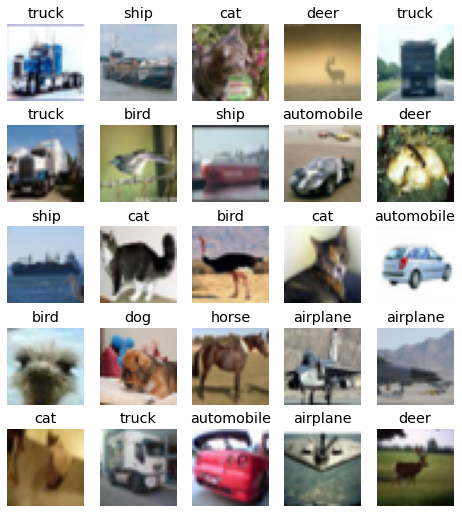

In [8]:
fig, axes = plt.subplots(5,5, figsize=(8,9))
for i, ax in enumerate(axes.flat):
  ax.imshow(images[i])
  ax.axis('off')
  idx = labels[i]
  ax.set_title(classnames[idx])
plt.show()

In [9]:
def train_gen(batch_size, shuffle_buffer):
  return tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(shuffle_buffer).batch(batch_size)
  # while True:
  #   offset = np.random.randint(0, x_train.shape[0] - batch_size)
  #   yield x_train[offset:offset+batch_size], y_train[offset:offset + batch_size]

def val_gen(batch_size):
  return tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)

# Build a model

In [10]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))
model.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))
model.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         7

In [11]:
model2 = tf.keras.models.clone_model(model)
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         7

# Train

Train the model

Training configurations

In [12]:
SCA = tf.keras.metrics.SparseCategoricalAccuracy

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = SCA(name='sparse_categorical_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = SCA(name='val_sparse_categorical_accuracy')

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
batch_size = 1024
shuffle_buffer = 50000
epochs = 10
steps_per_epoch = np.ceil(x_train.shape[0]/batch_size).astype(int)

In [13]:
model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[train_accuracy]
)

In [14]:
# Dummy run
history = model.fit(
    train_gen(batch_size, shuffle_buffer), 
    epochs=1, 
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen(batch_size),
)

40/40 [==============================] - 7s 78ms/step - loss: 2.2822 - sparse_categorical_accuracy: 0.2149 - val_loss: 2.3301 - val_sparse_categorical_accuracy: 0.1044


In [15]:
start = time()
history = model.fit(
    train_gen(batch_size, shuffle_buffer), 
    epochs=epochs, 
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen(batch_size),
)
end = time()

Epoch 1/10
40/40 [==============================] - 3s 65ms/step - loss: 1.5781 - sparse_categorical_accuracy: 0.4500 - val_loss: 2.8325 - val_sparse_categorical_accuracy: 0.1005
Epoch 2/10
40/40 [==============================] - 3s 64ms/step - loss: 1.3519 - sparse_categorical_accuracy: 0.5296 - val_loss: 3.3904 - val_sparse_categorical_accuracy: 0.1005
Epoch 3/10
40/40 [==============================] - 3s 65ms/step - loss: 1.2132 - sparse_categorical_accuracy: 0.5735 - val_loss: 3.9942 - val_sparse_categorical_accuracy: 0.1005
Epoch 4/10
40/40 [==============================] - 3s 64ms/step - loss: 1.1051 - sparse_categorical_accuracy: 0.6130 - val_loss: 4.2392 - val_sparse_categorical_accuracy: 0.1005
Epoch 5/10
40/40 [==============================] - 3s 64ms/step - loss: 1.0293 - sparse_categorical_accuracy: 0.6413 - val_loss: 4.5904 - val_sparse_categorical_accuracy: 0.1005
Epoch 6/10
40/40 [==============================] - 3s 66ms/step - loss: 0.9775 - sparse_categorical_accu

In [16]:
print(f'Total training time {end - start} seconds')

Total training time 32.68489074707031 seconds


In [17]:
from tensorflow.keras.utils import Progbar

@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model2(images, training=True)
    loss = loss_fn(labels, predictions)
  gradients = tape.gradient(loss, model2.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model2.trainable_variables))
  # Container to keep the results.
  train_loss(loss)
  train_accuracy(labels, predictions)

@tf.function
def val_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model2(images, training=False)
  v_loss = loss_fn(labels, predictions)
  # Container to keep the results.
  val_loss(v_loss)
  val_accuracy(labels, predictions)

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
mini_batches = len(train_gen(batch_size, shuffle_buffer))

start = time()
for epoch in range(epochs):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  print(f"Epoch {epoch+1}/{epochs}")
  pb_i = Progbar(mini_batches, stateful_metrics=['Loss', 'Accuracy', 
                                                 'Val Loss', 'Val Accuracy'])

  for idx, (images, labels) in enumerate(train_gen(batch_size, shuffle_buffer)):
    train_step(images, labels)
    if idx + 1 < mini_batches:
      pb_i.add(1, values=[('Loss', train_loss.result()), 
                          ('Accuracy', train_accuracy.result())])

  for val_images, val_labels in val_gen(batch_size):
    val_step(val_images, val_labels)
  pb_i.add(1, values=[('Loss', train_loss.result()), 
                      ('Accuracy', train_accuracy.result()),
                      ('Val Loss', val_loss.result()), 
                      ('Val Accuracy', val_accuracy.result())])

  # print(
  #   f'Epoch {epoch + 1:3d}/{epochs:3d}\n'
  #   f'Loss: {train_loss.result():.4f}, '
  #   f'Accuracy: {train_accuracy.result():.4f}, '
  #   f'Val Loss: {val_loss.result():.4f}, '
  #   f'Val Accuracy: {val_accuracy.result():.4f}'
  # )

  train_losses.append(train_loss.result())
  train_accuracies.append(train_accuracy.result())
  val_losses.append(val_loss.result())
  val_accuracies.append(val_accuracy.result())

end = time()

Epoch 1/10
40/40 [==============================] - 4s 64ms/step - Loss: 2.1371 - Accuracy: 0.2264 - Val Loss: 2.3013 - Val Accuracy: 0.1200
Epoch 2/10
40/40 [==============================] - 3s 50ms/step - Loss: 1.7061 - Accuracy: 0.4224 - Val Loss: 3.2576 - Val Accuracy: 0.1005
Epoch 3/10
40/40 [==============================] - 3s 50ms/step - Loss: 1.3906 - Accuracy: 0.5270 - Val Loss: 4.0144 - Val Accuracy: 0.1005
Epoch 4/10
40/40 [==============================] - 3s 50ms/step - Loss: 1.1883 - Accuracy: 0.5903 - Val Loss: 4.4723 - Val Accuracy: 0.1005
Epoch 5/10
40/40 [==============================] - 3s 50ms/step - Loss: 1.0706 - Accuracy: 0.6299 - Val Loss: 4.6818 - Val Accuracy: 0.1005
Epoch 6/10
40/40 [==============================] - 3s 50ms/step - Loss: 0.9878 - Accuracy: 0.6612 - Val Loss: 4.6952 - Val Accuracy: 0.1021
Epoch 7/10
40/40 [==============================] - 3s 55ms/step - Loss: 0.9167 - Accuracy: 0.6819 - Val Loss: 3.7521 - Val Accuracy: 0.1247
Epoch 8/10
40

In [18]:
print(f'Total training time {end - start} seconds')

Total training time 30.010439157485962 seconds


### Plot Loss and Accuracy

In [19]:
def plot(losses, accuracies, subplot_title):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
  
  ax1.plot(losses)
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title(subplot_title[0])
  
  ax2.plot(accuracies)
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title(subplot_title[1])
    
  plt.show()

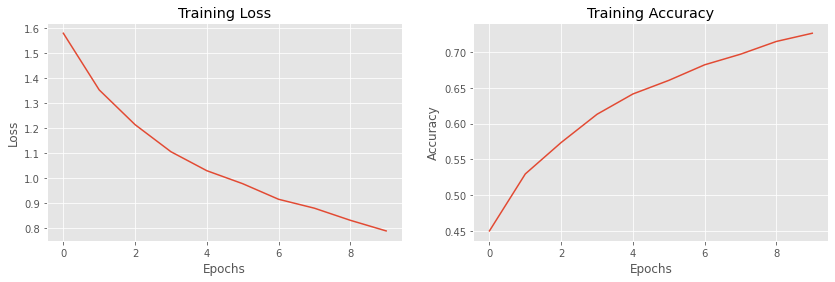

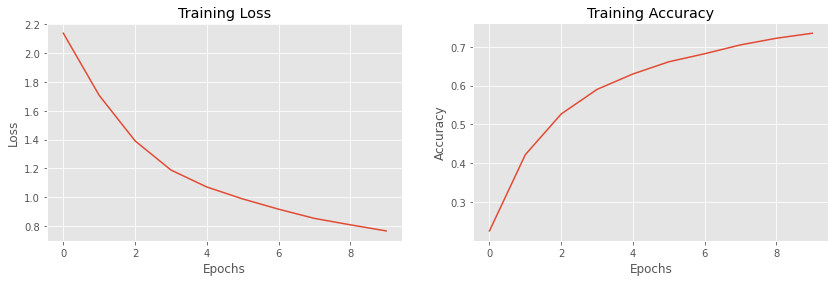

In [20]:
# Training
plot(history.history['loss'], 
     history.history['sparse_categorical_accuracy'], 
     subplot_title=['Training Loss', 'Training Accuracy']
    )
plot(train_losses, 
     train_accuracies, 
     subplot_title=['Training Loss', 'Training Accuracy']
    )

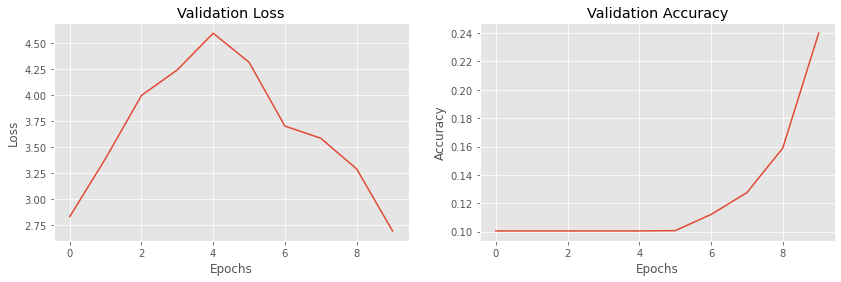

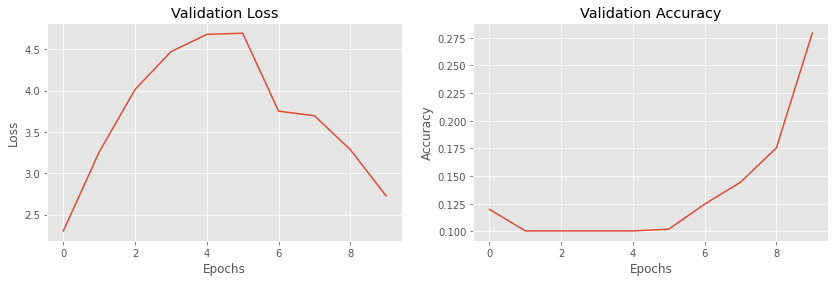

In [21]:
# Validation
plot(history.history['val_loss'], 
     history.history['val_sparse_categorical_accuracy'], 
     subplot_title=['Validation Loss', 'Validation Accuracy']
    )
plot(val_losses, 
     val_accuracies, 
     subplot_title=['Validation Loss', 'Validation Accuracy']
    )

# Test accuracy

Next, we plot the model predictions on test set

In [22]:
idxs = np.random.randint(x_test.shape[0], size=25)
images = x_test[idxs]
true_labels = y_test[idxs]

preds = np.argmax(model.predict(images), axis=1)
preds2 = np.argmax(model2.predict(images), axis=1)

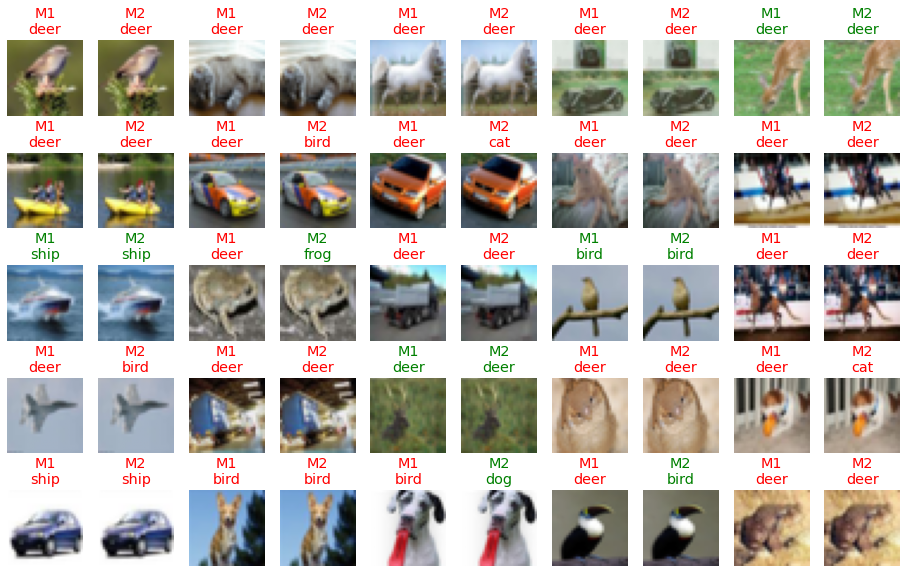

In [23]:
fig, axes = plt.subplots(5,10, figsize=(16,10))
for i, ax in enumerate(axes.flat):
  ax.imshow(images[i//2])
  ax.axis('off')
  if i%2 == 0:
    idx = preds[i//2]
    title = f"M1\n{classnames[idx]}"
  else:
    idx = preds2[i//2]
    title = f"M2\n{classnames[idx]}"
  color = 'g' if idx == true_labels[i//2] else 'r'
  ax.set_title(title, color=color)

plt.show()

In [24]:
def test_gen(batch_size):
  return tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

In [25]:
loss, acc = model.evaluate(test_gen(batch_size))
print(
  f'Loss: {loss:.4f}, '
  f'Accuracy: {acc:.4f}'
)

10/10 [==============================] - 0s 32ms/step - loss: 2.7042 - sparse_categorical_accuracy: 0.2378
Loss: 2.7042, Accuracy: 0.2378


In [26]:
test_loss = tf.keras.metrics.Mean(name='val_loss')
test_accuracy = SCA(name='val_sparse_categorical_accuracy')

@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model2(images, training=False)
  t_loss = loss_fn(labels, predictions)
  # Container to keep the results.
  test_loss(t_loss)
  test_accuracy(labels, predictions)

test_loss.reset_states()
test_accuracy.reset_states()
for t_images, t_labels in test_gen(batch_size):
  test_step(t_images, t_labels)

print(
  f'Loss: {test_loss.result():.4f}, '
  f'Accuracy: {test_accuracy.result():.4f}'
)

Loss: 2.7086, Accuracy: 0.2839
